# Imports

In [ ]:
from xgboost import XGBClassifier
print("base:")
bst = XGBClassifier()
bst.fit(nX_train, y_train)
preds = bst.predict(nX_test)
printClaStatistics(y_test, preds)

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, make_scorer
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

# Data treatment

In [8]:
data_url = 'proj-data.csv'
data = pd.read_csv(data_url,sep=',',header=0)

hyperthyroid_conditions = ['A', 'B', 'C', 'D']
hypothyroid_conditions = ['E', 'F', 'G', 'H']
binding_protein = ['I', 'J']
general_health = ['K']
replacement_therapy = ['L', 'M', 'N']
discordant_results = ['R']

for d in range(len(data)):
    if data.at[d, "diagnoses"] in hyperthyroid_conditions :
        data.at[d, "diagnoses"] = 1
    elif data.at[d, "diagnoses"] in hypothyroid_conditions :
        data.at[d, "diagnoses"] = 2
    elif data.at[d, "diagnoses"] in binding_protein :
        data.at[d, "diagnoses"] = 3
    elif data.at[d, "diagnoses"] in general_health :
        data.at[d, "diagnoses"] = 4
    elif data.at[d, "diagnoses"] in replacement_therapy :
        data.at[d, "diagnoses"] = 5
    elif data.at[d, "diagnoses"] in discordant_results :
        data.at[d, "diagnoses"] = 6
    elif data.at[d, "diagnoses"] == "-" :
        data.at[d, "diagnoses"] = 7 # no condition
    else:
        data.at[d, "diagnoses"] = 8 # others

data.drop('T4U measured:', axis=1, inplace=True)
data.drop('TT4 measured:', axis=1, inplace=True)
data.drop('FTI measured:', axis=1, inplace=True)
data.drop('TBG measured:', axis=1, inplace=True)
data.drop('TSH measured:', axis=1, inplace=True)
data.drop('T3 measured:', axis=1, inplace=True)

data.replace('?', np.nan, inplace=True)
data.replace('f', 0, inplace=True)
data.replace('t', 1, inplace=True)

data

,age:,sex:,on thyroxine:,query on thyroxine:,on antithyroid medication:,sick:,pregnant:,thyroid surgery:,I131 treatment:,query hypothyroid:,...,psych:,TSH:,T3:,TT4:,T4U:,FTI:,TBG:,referral source:,diagnoses,[record identification]
0,29,F,0,0,0,0,0,0,0,1,...,0,0.3,NaN,NaN,NaN,NaN,NaN,other,7,[861106018]
1,29,F,0,0,0,0,0,0,0,0,...,0,1.6,1.9,128,NaN,NaN,NaN,other,7,[860916073]
2,36,F,0,0,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,26,other,7,[850726049]
3,60,F,0,0,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,26,other,7,[861010020]
4,77,F,0,0,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,21,other,7,[860324074]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7333,56,M,0,0,0,0,0,0,0,0,...,0,NaN,NaN,64,0.83,77,NaN,SVI,7,[850725042]
7334,22,M,0,0,0,0,0,0,0,0,...,0,NaN,NaN,91,0.92,99,NaN,SVI,7,[840816047]
7335,69,M,0,0,0,0,0,0,0,0,...,0,NaN,NaN,113,1.27,89,NaN,SVI,3,[840910050]
7336,47,F,0,0,0,0,0,0,0,0,...,0,NaN,NaN,75,0.85,88,NaN,other,7,[860317010]


In [9]:
#identify columns with empty values
result = {}

#Quantos nulos tem cada coluna
for j in data.values:
  count=0
  for s in j:
    if pd.isna(s):
      if data.columns[count] not in result:
        result[data.columns[count]] = 1
      else:
        result[data.columns[count]] += 1
    count+=1

for r in result.keys():
  if result[r] > 0:
    print("column " + r + " " + str(result[r]) + " missing values")

X_values = data.iloc[:,:-2]
X_values.drop('TBG:',axis=1,inplace=True)
X_values.drop('T3:',axis=1,inplace=True)
X_values.drop('sex:',axis=1,inplace=True) # ASSUMINDO QUE O SEXO NÃO É RELEVANTE
X_values.drop('referral source:',axis=1,inplace=True) # ASSUMINDO QUE A FONTE DE REFERÊNCIA NÃO É RELEVANTE
y_value = data.iloc[: , -2:-1]
y_value = y_value.astype('int')
print(X_values)
print(y_value)

column T3: 2068 missing values
column TT4: 362 missing values
column T4U: 664 missing values
column FTI: 658 missing values
column TBG: 7054 missing values
column TSH: 671 missing values
column sex: 240 missing values
      age:  on thyroxine:  query on thyroxine:  on antithyroid medication:  \
0       29              0                    0                           0   
1       29              0                    0                           0   
2       36              0                    0                           0   
3       60              0                    0                           0   
4       77              0                    0                           0   
...    ...            ...                  ...                         ...   
7333    56              0                    0                           0   
7334    22              0                    0                           0   
7335    69              0                    0                           0   
73

In [10]:
#TRAIN & TEST SET
X_train, X_test, y_train, y_test = train_test_split(X_values, y_value, test_size=0.25,random_state=0)

#SCALING
scaler = StandardScaler()
scaler.fit(X_train)
Xt_train=scaler.fit_transform(X_train)
Xt_test=scaler.fit_transform(X_test)

#IMPUTER
imputer = KNNImputer(weights="uniform")
imputer.fit(X_train)
Xt_train = imputer.transform(X_train)
Xt_test = imputer.transform(X_test)

#FEATURE SELECTION
N,M = Xt_train.shape


rfr=RandomForestRegressor(random_state=0)
sel = SelectFromModel(estimator=rfr,threshold=0.015)
y_train = y_train.squeeze().ravel()
y_test = y_test.squeeze().ravel()
sel.fit(Xt_train, y_train)

print("Default threshold: ", sel.threshold_)

features=sel.get_support()
Features_selected =np.arange(M)[features]

print("The features selected are columns: ", Features_selected)

nX_train=sel.transform(Xt_train)
nX_test=sel.transform(Xt_test)

score = make_scorer(matthews_corrcoef)

def  printClaStatistics(TRUTH_nfold, PREDS_nfold):   
    print("These are the training set statistics:")
    print("The Accuracy is: %7.4f" % accuracy_score(TRUTH_nfold, PREDS_nfold))
    print("The Precision is: %7.4f" % precision_score(TRUTH_nfold, PREDS_nfold, average='weighted'))
    print("The Recall is: %7.4f" % recall_score(TRUTH_nfold, PREDS_nfold, average='weighted'))
    print("The F1 score is: %7.4f" % f1_score(TRUTH_nfold, PREDS_nfold, average='weighted'))
    print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(TRUTH_nfold, PREDS_nfold))
    print(pd.DataFrame(confusion_matrix(TRUTH_nfold, PREDS_nfold)))


Default threshold:  0.015
The features selected are columns:  [ 0  1 15 16 17 18]


Feature ranking:
1. feature 15 (0.259503)
2. feature 18 (0.198468)
3. feature 16 (0.179394)
4. feature 17 (0.147050)
5. feature 0 (0.104116)
6. feature 1 (0.049214)
7. feature 9 (0.008998)
8. feature 5 (0.008113)
9. feature 8 (0.007828)
10. feature 4 (0.006061)
11. feature 2 (0.005694)
12. feature 12 (0.005661)
13. feature 6 (0.004506)
14. feature 14 (0.003875)
15. feature 3 (0.003707)
16. feature 7 (0.003552)


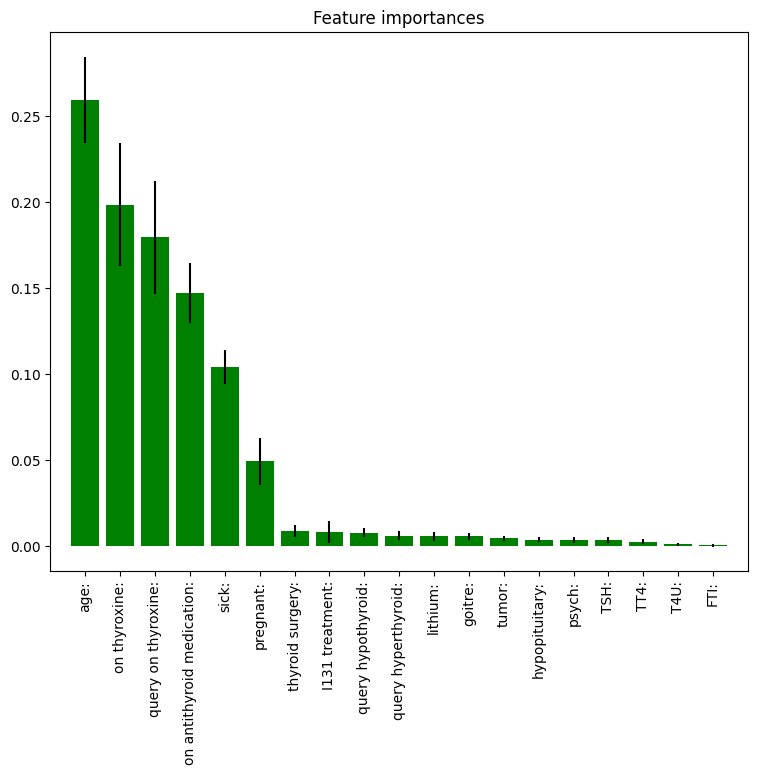

In [11]:
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(Xt_train,y_train)

clf_rf_4 = RandomForestClassifier()      
clr_rf_4 = clf_rf_4.fit(Xt_train,y_train)
importances = clr_rf_4.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
 
#Print the feature ranking
print("Feature ranking:")
 
for f in range(16):
    print("%d. feature %d (%f)" % (f + 1, indices[f],  importances[indices[f]]))
 
#Plot the feature importances list:
plt.figure(1, figsize=(9,7))
plt.title("Feature importances")
plt.bar(range(Xt_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_values.shape[1]), X_values.columns,rotation=90)
plt.xlim([-1, Xt_train.shape[1]])
plt.show()

# Classification Methods

## Decision Tree


In [12]:
from sklearn import tree

print("base:")
dt = tree.DecisionTreeClassifier()
dt.fit(nX_train , y_train)
preds = dt.predict(nX_test)
printClaStatistics(y_test, preds)

print()
print("best:")
cs = ["gini", "entropy"]
md = [None,*range(3, 30)]
msl=[*range(1,15)]
mss=[*range(2,15)]
param_grid = {"criterion": cs, "max_depth": md, "min_samples_leaf": msl, "min_samples_split": mss}
gs = GridSearchCV(estimator=dt, param_grid=param_grid, scoring=score)
gs.fit(nX_train , y_train)
preds=gs.best_estimator_.predict(nX_test)
printClaStatistics(y_test, preds)

print("best criterion : " ,gs.best_estimator_.criterion)
print("best max_depth : " ,gs.best_estimator_.max_depth)
print("best min_samples_leaf : " ,gs.best_estimator_.min_samples_leaf)
print("best min_samples_split : " ,gs.best_estimator_.min_samples_split)


base:
These are the training set statistics:
The Accuracy is:  0.7831
The Precision is:  0.7874
The Recall is:  0.7831
The F1 score is:  0.7849
The Matthews correlation coefficient is:  0.5229
    0   1   2   3   4   5     6   7
0  19   0   2   0   1   2     8   4
1   0  87   0   0   0   0    25  10
2   1   0  36   1   0   1    36   0
3   0   0   1  26   1   1    61   3
4   1   0   1   0  57   2     7   7
5   4   0   2   0   2  21     8   2
6   8  11  21  80   6  14  1178  20
7   3  11   2   1   5   2    20  13

best:


KeyboardInterrupt: 

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
print("base:")
mdl=GaussianNB()
mdl.fit(nX_train , y_train)
preds = mdl.predict(nX_test)

printClaStatistics(y_test, preds)

## K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def gaussian(dsts):
    kernel_width = .5
    weights = np.exp(-(dsts**2)/kernel_width)
    return weights

print("base:")
knn = KNeighborsClassifier()
knn.fit(nX_train , y_train)
preds = knn.predict(nX_test)
printClaStatistics(y_test, preds)

print()
print("best:")
nn=[3,5,7,9,11]
w=["distance","uniform",gaussian]

param_grid = {"n_neighbors":nn,"weights":w}
gs = GridSearchCV(estimator=knn, param_grid=param_grid, scoring=score)
gs.fit(nX_train , y_train)
preds=gs.best_estimator_.predict(nX_test)

printClaStatistics(y_test, preds)

print("best n_neighbors : " ,gs.best_estimator_.n_neighbors)
print("best weights : " ,gs.best_estimator_.weights)


## SVM

In [ ]:
from sklearn.svm import SVC

# Compute the minimum value per feature on training set
min_on_training = nX_train.min(axis=0)
# Compute the range of each feature (max - min) on  training set
range_on_training = (nX_train - min_on_training).max(axis=0)

# subtract the min, divide by range
# afterward, min=0 and max=1 for each feature
X_train_scaled = (nX_train - min_on_training) / range_on_training

# use THE SAME transformation on the test set,
# using min and range of the training set. See Chapter 3 (unsupervised learning) for details.
X_test_scaled = (nX_test - min_on_training) / range_on_training

clf = SVC(C = 1, gamma=0.1)
svc= clf.fit(X_train_scaled, y_train)
preds = svc.predict(X_test_scaled)

printClaStatistics(y_test, preds)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=9,criterion='entropy')
rf.fit(nX_train, y_train)
preds=rf.predict(nX_test)
printClaStatistics(y_test, preds)

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=50,random_state=0)
abc.fit(nX_train, y_train)
preds=abc.predict(nX_test)

printClaStatistics(y_test, preds)

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

print("base:")
gbc = GradientBoostingClassifier()
gbc.fit(nX_train, y_train)
preds = gbc.predict(nX_test)
printClaStatistics(y_test, preds)

print()
print("best:")

ne = [*range(10,200,10)]
lr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
param_grid = {"n_estimators":ne,"learning_rate":lr}
gs = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring=score)
gs.fit(nX_train , y_train)
preds=gs.best_estimator_.predict(nX_test)

printClaStatistics(y_test, preds)

print("best n_estimators : " ,gs.best_estimator_.n_estimators)
print("best learning_rate : " ,gs.best_estimator_.learning_rate)

## XGBoost